# Read temperature data from weather mast at Haukeliseter site

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np 
import csv
import pandas as pd
import datetime
from datetime import date
import calendar


%matplotlib inline    



In [2]:
Hauke = pd.read_csv('../Retrieval/201612.Haukeliseter_SC_copy.txt',\
                    sep = ',',header=0)

In [3]:
dd = Hauke['Date']
time = Hauke['TimeStamp']     # Time Stamp
df1 = Hauke['RA1'].astype(float)            # total accumulation from Geonor inside DOUBLE FENCE [mm] RA1
df2 = Hauke['RA2'].astype(float)
df3 = Hauke['RA3'].astype(float)
sf1 = Hauke['X2RA1'].astype(float)          # Total accumulation from Geonor South, shielded with SINGLE FENCE [mm] X2RA1
sf2 = Hauke['X2RA2'].astype(float)
sf3 = Hauke['X2RA3'].astype(float)
temp = Hauke['TA'].astype(float)            # Air temperature, PT100 [deg C] TA
wind45 = Hauke['3DFFL4']      # wind speed 4.5m @ mast 2 [m/s] 3DFFL4


df1 = df1.where(df1 != -999.00)
df2 = df2.where(df2 != -999.00)
df3 = df3.where(df3 != -999.00)
sf1 = sf1.where(sf1 != -999.00)
sf2 = sf2.where(sf2 != -999.00)
sf3 = sf3.where(sf3 != -999.00)
temp = temp.where(temp != -999.00)
wind45 = wind45.where(wind45 != -999.00)

In [4]:
# --------- SET DAYS WHERE 1440 MIN PER 24H ----------------------------------------------
dy = np.zeros((32,1))

for i in range(0,32):
    dy[i,:] = i*1440.     # begin of the new day 00:00:00
    


In [ ]:
# --------- PRINT OUT TEMP FILES FOR A PRIORI GUESS --------------------------------------
idx = np.arange((1440))
t = np.zeros((1440,32))
filename = []


for i in range(0,31):
    t[:,i] = temp[i*1440:(i+1)*1440]
print(t[:,0])

for day in range(1,32):
    if day < 10:
        day = str(day)
        day = '0%s' %day
    else:
        day = str(day)

    filename.append('../Observations/hauk_temp/surftemp_201612%s.dat' %day)

for i in range(0,31):
    np.savetxt(filename[i], np.transpose([idx,t[:,i]]), fmt = '%1.i %2.5f')


In [5]:
# --------- CALCULATE DAILY TOTAL SNOWFALL -----------------------------------------------
acc1_day = np.zeros((32,1))
acc2_day = np.zeros((32,1))
acc3_day = np.zeros((32,1))

for i in range(0,31):
    bot = dy[i]                                       # lower amount of snow from previous day
    top = dy[i+1]-1                                   # top of snow amount after 1 day snowfall
    acc1_day[i,:] = float(df1[top])-float(df1[bot])   # Sensor 1 DOUBLE FENCE
                                                      # daily snowfall by subtracting the snow accumulation of the end of the day from the
                                                      # end of the previous day
    acc2_day[i,:] = float(df2[top])-float(df2[bot])   # Sensor 2 DOUBLE FENCE
    acc3_day[i,:] = float(df3[top])-float(df3[bot])   # Sensor 3 DOUBLE FENCE

acc_avg = (acc1_day+acc2_day+acc3_day)/3.
acc_day = np.c_[acc1_day, acc2_day, acc3_day]
acc_avg = np.mean(acc_day,axis =1)
#print(acc1_day)
#print(acc2_day)
#print(acc3_day)




In [6]:
# --------- CALCULATE ACCUMULATION DURING A GIVEN DAY ------------------------------------
df = np.c_[df1, df2, df3]
sf = np.c_[sf1, sf2, sf3]

# axis=1 will return the mean of every single row in the DataFrame
dfavg = np.mean(df, axis = 1)       # arithmetic mean of the total accumulation DOUBLE FENCE for each minute
sfavg = np.mean(df, axis = 1)       #                                           SINGLE FENCE

#print(dfavg[8640+0+1],dfavg[8640+1+1])
#(df1+df2+df3)/3.


In [ ]:
tt = np.empty((1,1440))
tt[:] = np.NAN

accDF = np.zeros((1440,33))
accSF = np.zeros((1440,33))

for k in range(0,30):
    dy_no = int(dy[k,:])                     # index is day of month minus one
                                             # select  day through index (e.g. 0 is Day 1)
    totDF = 0.
    totSF = 0.
    for j in range(0,1440):
        tt[:,j] = (1/60)*float(j)                        # convert time from minute to 100th of an hour
        #tt[:,j] = float(j)
        ## DOUBLE FENCE
        totDF = totDF + (dfavg[dy_no+j+1] - dfavg[dy_no+j]) # snow accumulation per minute plus previous amount
        accDF[j,k] = totDF                                  # DOUBLE FENCE accumulation of the day by using the mean 
                                                            # of the three double fence values per minute
        ## SINGLE FENCE
        totSF = totSF + (sfavg[dy_no+j+1] - sfavg[dy_no+j])
        accSF[j,k] = totSF
        


In [ ]:
filename = '../Observations/hauk_temp/accDF.dat' 
np.savetxt(filename, accDF, fmt = '%2.5f')

NameError: name 'tt' is not defined

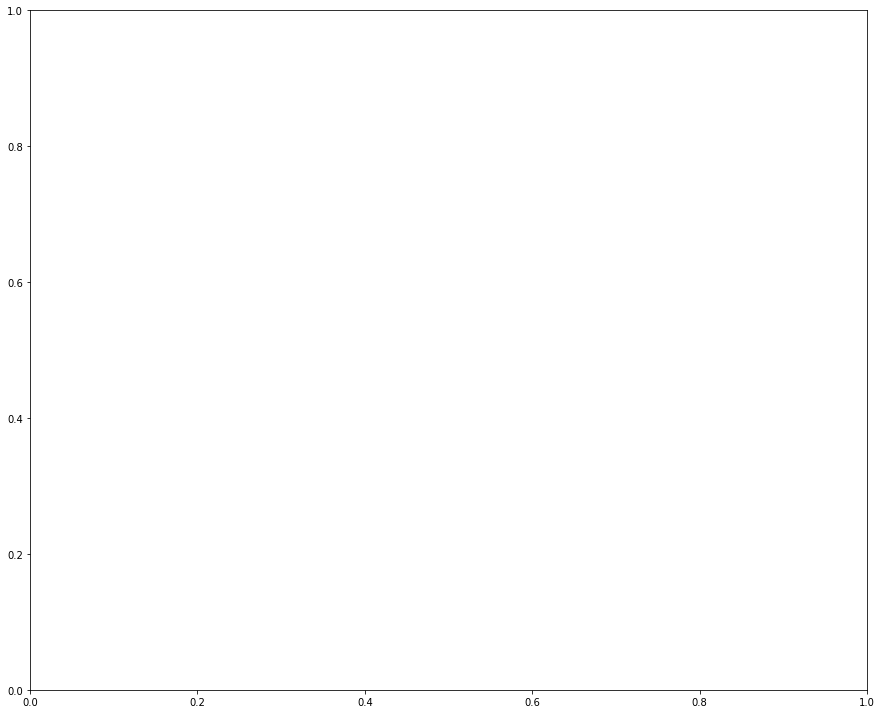

In [7]:
times = [0, 3, 6, 9, 12, 15, 18, 21, 24]
yr = int(2016)
mo = int(12)

for day in range(5,32):  # start from 6th December
    day = day
    if day < 10:
        day = str(day)
        day = '0%s' %day
    else:
        day = str(day)
 

   
    dy = int(day)
    my_date = date(yr,mo,dy)
    calday = calendar.day_name[my_date.weekday()]
    calmon = calendar.month_abbr[mo]
    
    fig = plt.figure(figsize=(15,12.5))
    ax = fig.add_subplot(1,1,1)
    plt.plot(np.transpose(tt),accDF[:,(dy)])
    #,np.transpose(tt),accSF[:,(dy-1)],'bs')
    
    
    
    fig.suptitle('%s, %s %s %s' %(calday, day, calmon, yr), fontsize=16, fontweight='bold')
    
    ax.set_xlim([0,24])
    ax.set_xticks(times)
    ax.set_xlabel('Hour', fontsize = 16)
        
    timer = ['00Z', '03Z','06Z','09Z','12Z','15Z','18Z','21Z','24Z']
    ax.set_xticklabels(timer, fontsize = 16)#, rotation=45,fontsize=10)    # rotate x label
    
    
    #ax.set_yticks(np.arange(0,13))
    ax.set_ylabel('Accumulation (mm)', fontsize = 16)
    #ax.set_yticklabels(np.arange(0,13),fontsize = 16)
    
    ### Save
    plt.savefig('../Observations/figs/%s%s%s_acc.png' % (yr, mo, day))
    plt.close(fig)
        #ax.set_ylim([0,70])
    #ax.set_ylabel('Accumulation (mm)', fontsize = 16)